In [199]:
import pandas as pd
from sklearn.cluster import KMeans

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [265]:
with open('../datasets/data/bob-ross/elements-by-episode.csv') as infile:
    data = pd.read_csv(infile)
    data.drop(['EPISODE', 'TITLE', 'TREE', 'TREES', 'DECIDUOUS', 'CONIFER', 'CLOUDS', 'MOUNTAIN', 'MOUNTAINS', 'SNOWY_MOUNTAIN'], axis=1, inplace=True)
data.head()

,APPLE_FRAME,AURORA_BOREALIS,BARN,BEACH,BOAT,BRIDGE,BUILDING,BUSHES,CABIN,CACTUS,...,STRUCTURE,SUN,TOMB_FRAME,TRIPLE_FRAME,WATERFALL,WAVES,WINDMILL,WINDOW_FRAME,WINTER,WOOD_FRAMED
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
def count_occ(df):
    count_dict = {}
    for name in df.columns.values:
        count_dict[name] = df[name].sum()
    return Counter(count_dict)

def plot_counts(counts, ax, order, c='b'):
    counts_sorted = [counts[key] for key in order]

    ax.bar(np.arange(len(order)), counts_sorted, color=c, alpha=0.2)

In [267]:
l = len(data)
for word, count in count_occ(data).most_common():
    print(word, count/l*100)

LAKE 35.4838709677
GRASS 35.2357320099
RIVER 31.2655086849
BUSHES 29.776674938
CUMULUS 21.3399503722
STRUCTURE 21.0918114144
ROCKS 19.1066997519
SNOW 18.6104218362
CABIN 17.1215880893
WINTER 17.1215880893
FRAMED 13.1513647643
PATH 12.158808933
SUN 9.92555831266
WATERFALL 9.67741935484
OVAL_FRAME 9.42928039702
OCEAN 8.93300248139
WAVES 8.43672456576
CIRRUS 6.94789081886
BEACH 6.69975186104
FENCE 5.95533498759
FOG 5.70719602978
GUEST 5.45905707196
HILLS 4.46650124069
BARN 4.21836228288
FLOWERS 2.9776674938
STEVE_ROSS 2.72952853598
NIGHT 2.72952853598
PALM_TREES 2.23325062035
CLIFF 1.98511166253
BRIDGE 1.73697270471
CACTUS 0.992555831266
PORTRAIT 0.744416873449
MOON 0.744416873449
AURORA_BOREALIS 0.496277915633
CIRCLE_FRAME 0.496277915633
BOAT 0.496277915633
MILL 0.496277915633
APPLE_FRAME 0.248138957816
WINDOW_FRAME 0.248138957816
FARM 0.248138957816
PERSON 0.248138957816
DIANE_ANDRE 0.248138957816
FIRE 0.248138957816
HALF_OVAL_FRAME 0.248138957816
LIGHTHOUSE 0.248138957816
RECTANGULAR_F

[('STRUCTURE', 25), ('LAKE', 25), ('CABIN', 25), ('WINTER', 10), ('SNOW', 10), ('FRAMED', 8), ('BUSHES', 8)]
[('LAKE', 43), ('GRASS', 29), ('GUEST', 10), ('PATH', 10), ('ROCKS', 9), ('CIRRUS', 7), ('SUN', 7)]
[('RIVER', 67), ('GRASS', 38), ('ROCKS', 27), ('WATERFALL', 20), ('FRAMED', 9), ('OVAL_FRAME', 8), ('CIRRUS', 8)]
[('BUSHES', 36), ('LAKE', 29), ('GRASS', 8), ('PATH', 8), ('FRAMED', 4), ('OVAL_FRAME', 3), ('ROCKS', 2)]
[('OCEAN', 35), ('WAVES', 34), ('BEACH', 27), ('ROCKS', 20), ('CUMULUS', 17), ('SUN', 10), ('PALM_TREES', 9)]
[('STRUCTURE', 25), ('PATH', 23), ('CABIN', 19), ('GRASS', 16), ('FENCE', 7), ('BARN', 7), ('CUMULUS', 5)]
[('WINTER', 27), ('SNOW', 26), ('STRUCTURE', 24), ('CABIN', 18), ('FENCE', 9), ('BARN', 7), ('OVAL_FRAME', 3)]
[('SNOW', 33), ('WINTER', 32), ('LAKE', 12), ('BUSHES', 9), ('RIVER', 8), ('FRAMED', 7), ('SUN', 6)]
[('CUMULUS', 33), ('LAKE', 30), ('BUSHES', 15), ('GRASS', 14), ('GUEST', 5), ('ROCKS', 4), ('HILLS', 3)]
[('BUSHES', 47), ('RIVER', 43), ('GRA

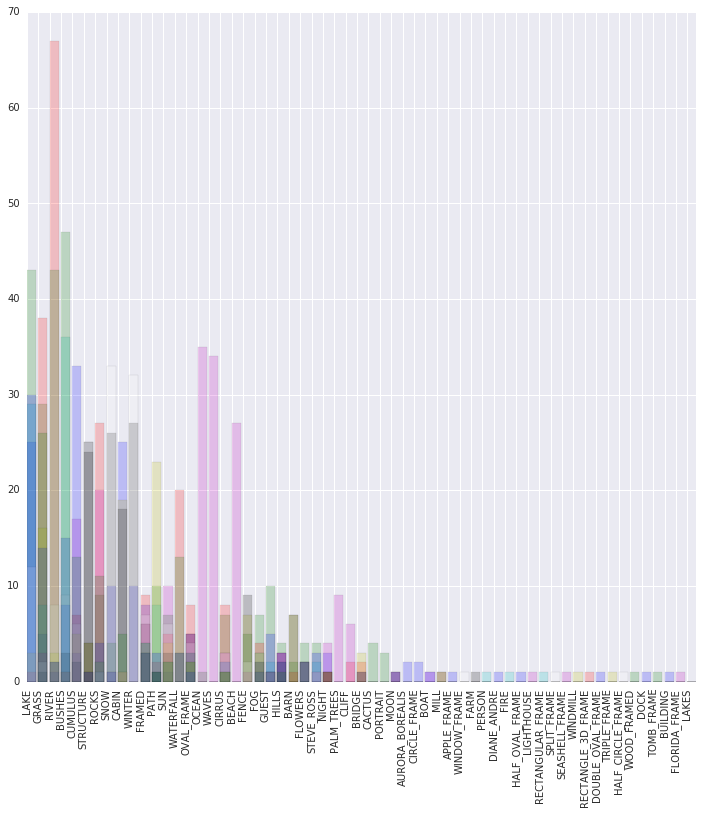

In [268]:
sorted_cols = [i[0] for i in count_occ(data).most_common()]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.xticks(np.arange(len(sorted_cols)), sorted_cols, rotation='vertical')
#plot_counts(count(data), ax, sorted_cols)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

n_clusters = 10
k_means = KMeans(n_clusters=n_clusters)
clusters = k_means.fit_predict(data)
for i in range(n_clusters):
    cluster = data[clusters == i]
    print(count_occ(cluster).most_common(7))
    plot_counts(count_occ(data[clusters == i]), ax, sorted_cols, c=colors[i%len(colors)])


plt.legend(map(str, range(n_clusters)))
plt.show()